In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

import plotly.express as px
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

In [2]:
data_dir = "/content/drive/MyDrive/zillow-prize-1"

# Read Property Information from 2016 and 2017
properties_2016 = pd.read_csv( data_dir +"/properties_2016.csv", low_memory=False)
properties_2017 = pd.read_csv( data_dir +"/properties_2017.csv", low_memory=False)

# Read Training Information
train_2016  = pd.read_csv( data_dir +"/train_2016_v2.csv", low_memory=False)
train_2017  = pd.read_csv( data_dir +"/train_2017.csv", low_memory=False)

# Read Submission Data
sample_submission_data = pd.read_csv(data_dir+'/sample_submission.csv', low_memory = False)

#merge training with properties
train_2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid').copy()
train_2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid').copy()

train_df = pd.concat([train_2016,train_2017],axis=0)
original_train_df=train_df
train_df # Merge Dataset from 2016 and 2017 for Train Data

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.168400,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.004000,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.021800,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.005000,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
77609,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
77610,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
77611,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13


In [3]:
train_df.dtypes

parcelid                          int64
logerror                        float64
transactiondate                  object
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object


In [4]:
print(train_df.shape)
train_df.describe()

(167888, 60)


,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,1.678880e+05,167888.000000,53788.000000,468.000000,93.000000,167854.000000,167854.000000,31.000000,107173.000000,166056.000000,...,165.000000,166828.000000,38169.000000,1.673590e+05,1.678520e+05,167854.000000,1.678510e+05,167843.000000,4683.000000,1.670020e+05
mean,1.299536e+07,0.013906,1.814345,7.299145,695.376344,2.288265,3.041739,3.967742,6.015461,2.312542,...,271.260606,1968.569311,1.437764,1.843460e+05,4.726833e+05,2015.462181,2.888805e+05,5989.515575,13.827247,6.049390e+13
std,3.016071e+06,0.165706,2.970239,2.719633,583.952144,1.000835,1.149134,0.179605,1.882799,0.977808,...,293.611447,23.777202,0.544508,2.192841e+05,6.028372e+05,0.498569,4.456451e+05,7214.731946,2.421658,1.054137e+12
min,1.071174e+07,-4.655420,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,...,12.000000,1824.000000,1.000000,4.400000e+01,2.200000e+01,2015.000000,2.200000e+01,19.920000,3.000000,6.037101e+13
25%,1.154899e+07,-0.025300,1.000000,7.000000,280.000000,2.000000,2.000000,4.000000,4.000000,2.000000,...,88.000000,1953.000000,1.000000,8.256800e+04,2.026522e+05,2015.000000,8.373000e+04,2798.070000,13.000000,6.037312e+13
50%,1.254060e+07,0.006000,1.000000,7.000000,588.000000,2.000000,3.000000,4.000000,7.000000,2.000000,...,160.000000,1970.000000,1.000000,1.340510e+05,3.500000e+05,2015.000000,1.977760e+05,4501.040000,14.000000,6.037604e+13
75%,1.421930e+07,0.039200,1.000000,7.000000,819.000000,3.000000,4.000000,4.000000,7.000000,3.000000,...,320.000000,1987.000000,2.000000,2.142570e+05,5.540020e+05,2016.000000,3.553340e+05,6914.165000,15.000000,6.059042e+13
max,1.676893e+08,5.262999,13.000000,21.000000,3560.000000,20.000000,16.000000,4.000000,12.000000,20.000000,...,1366.000000,2016.000000,6.000000,1.142179e+07,4.906124e+07,2016.000000,4.895220e+07,586639.300000,99.000000,4.830301e+14


In [5]:
percent_missing = train_df.isnull().sum() * 100 / len(train_df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
missing_value_df

,percent_missing
buildingclasstypeid,99.981535
finishedsquarefeet13,99.955327
storytypeid,99.944606
basementsqft,99.944606
yardbuildingsqft26,99.901720
fireplaceflag,99.765320
architecturalstyletypeid,99.721243
typeconstructiontypeid,99.689078
finishedsquarefeet6,99.519322
decktypeid,99.242352


In [6]:
fig = px.bar(missing_value_df, orientation='h')
fig.show()

In [7]:
print(train_df['logerror'].describe())

count    167888.000000
mean          0.013906
std           0.165706
min          -4.655420
25%          -0.025300
50%           0.006000
75%           0.039200
max           5.262999
Name: logerror, dtype: float64


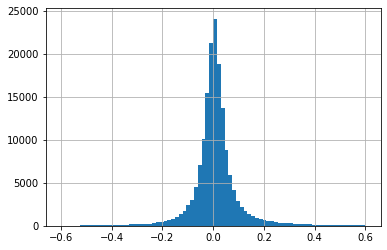

In [8]:
train_df.loc[abs(train_df['logerror']) < 0.6, 'logerror'].hist(bins=80)

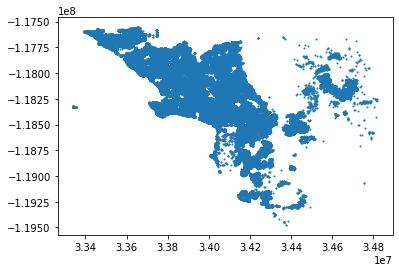

In [9]:
plt.scatter(train_df['latitude'],train_df['longitude'], s=1)

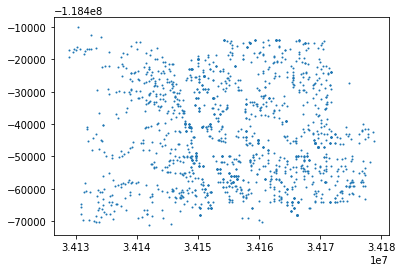

In [10]:
df_regionidneighborhood_1 = train_df[train_df['regionidneighborhood'] == 27080]
plt.scatter(df_regionidneighborhood_1['latitude'],df_regionidneighborhood_1['longitude'], s=1)

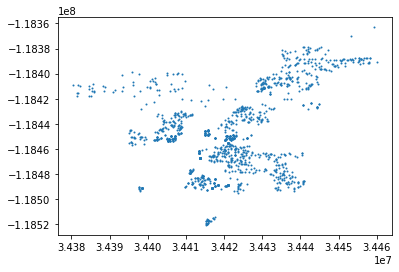

In [11]:
df_regionidneighborhood_2 = train_df[train_df['regionidneighborhood'] == 37739]
plt.scatter(df_regionidneighborhood_2['latitude'],df_regionidneighborhood_2['longitude'], s=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



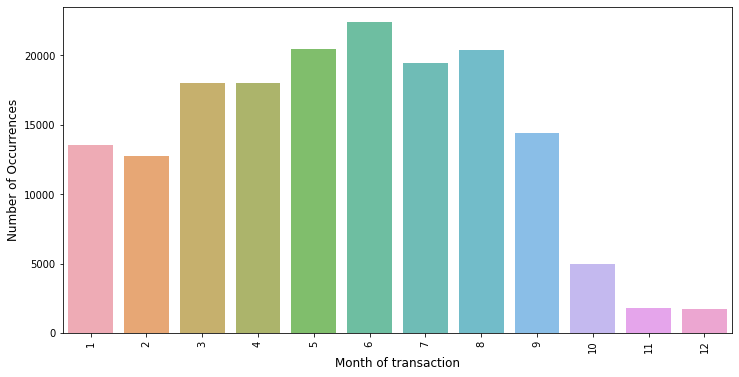

In [12]:
dt = pd.to_datetime(train_df['transactiondate']).dt
train_df['transaction_month'] = dt.month
cnt_srs=train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In [13]:
number_Encoded_Data=["airconditioningtypeid", "architecturalstyletypeid","buildingclasstypeid", "heatingorsystemtypeid", "propertylandusetypeid", "storytypeid", "typeconstructiontypeid"]
number_Encoded_Data

['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'heatingorsystemtypeid',
 'propertylandusetypeid',
 'storytypeid',
 'typeconstructiontypeid']

In [14]:
categorical = [col for col in train_df.columns if train_df[col].dtypes  in ['object'] ]
categorical

['transactiondate',
 'hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'taxdelinquencyflag']

In [15]:
continues_variables = [col for col in [col for col in train_df.columns if train_df[col].dtypes in ['int64','float64']] if col not in number_Encoded_Data]

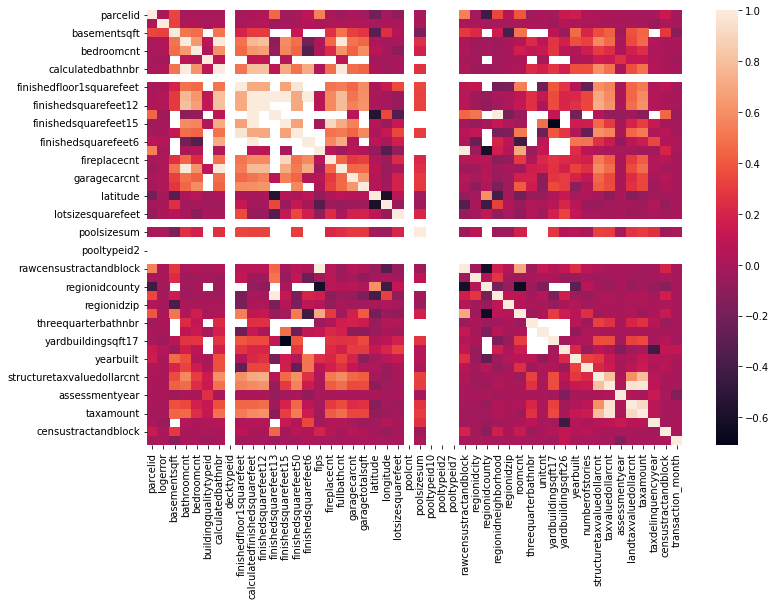

<Figure size 432x288 with 0 Axes>

In [16]:
#Use heatmap to determine if any continuous variables are correlated
plt.figure(figsize = (12,8))

sns.heatmap(data=train_df[continues_variables].corr())
plt.show()
plt.gcf().clear()

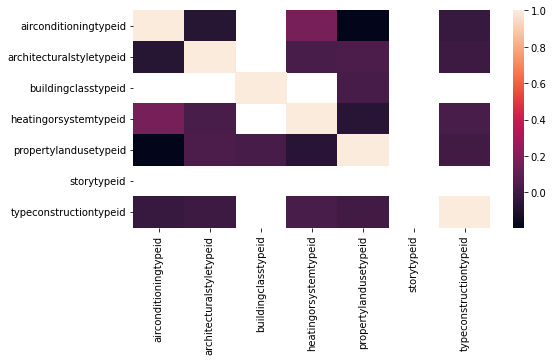

<Figure size 432x288 with 0 Axes>

In [17]:
#Use heatmap to determine if any discret variables are correlated
plt.figure(figsize = (8,4))
sns.heatmap(data=train_df[number_Encoded_Data].corr())
plt.show()
plt.gcf().clear()